In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import os
import time
import pandas as pd

In [2]:
def cal_metric(pro_coord, lig_coord):
    sums = 0
    for mi in range(3):
        sums += (pro_coord[mi] - lig_coord[mi]) ** 2
    return np.sqrt(sums)

def ES_formula(Q1, Q2, distance):
    return Q1 * Q2 / distance

In [3]:
pro_molpath = '/home/hhs/thaad/multi/1A4G_pro_mol_moved.csv'
lig_molpath = '/home/hhs/thaad/multi/1A4G_lig_mol_moved.csv'

grid_molpath = '/home/hhs/thaad/multi/grid_mol.csv'

In [4]:
pro_mol = pd.read_csv(pro_molpath)
lig_mol = pd.read_csv(lig_molpath)
grid_mol = pd.read_csv(grid_molpath)

In [7]:
#option1
start = time.time()
gr_get = []
grid_charge = 1
for i in range(len(grid_mol)):
    final_energy = 0.0
    grid_coord = grid_mol[['x','y','z']].iloc[i]
    for j in range(len(pro_mol)):
        pro_coord = pro_mol[['x','y','z']].iloc[j]
        pro_charge = pro_mol['charge'][j]
        distance = cal_metric(grid_coord, pro_coord)
        
        final_energy +=ES_formula(grid_charge, pro_charge, distance)
    gr_get.append(final_energy)
    #print('{}th finished.'.format(i))
print("time:{:.3f}".format(time.time()-start))

time:1909.100


In [12]:
#option2
start2 = time.time()
pro_npys = pro_mol[['x','y','z','charge']].values
grid_npy = grid_mol[['x','y','z']].values

final_list = []
grid_charge = 1
for i in range(len(grid_npy)):
    gr_np = grid_npy[i]
    final_energy = 0.0
    for j in range(len(pro_npys)):
        pro_coords = pro_npys[j]
        pro_coord = pro_coords[:3]
        pro_charge = pro_coords[3]
        distance = cal_metric(gr_np, pro_coord)
        
        final_energy +=ES_formula(grid_charge, pro_charge, distance)
    final_list.append(final_energy)
    
print("time:{:.3f}".format(time.time()-start2))

time:26.543


In [5]:
#option3
start3 = time.time()
pro_npys = pro_mol[['x','y','z','charge']].values
grid_npy = grid_mol[['x','y','z']].values



mod2 = SourceModule("""
__global__ void doublify2(float *p_a, float *g_a, float *gg_a)
{
for(int iter=0; iter < 3; iter++)
    {
    int idx = iter*9261+threadIdx.x+blockDim.x*blockIdx.x;
    int chk = threadIdx.x+blockDim.x*blockIdx.x;
    
    if (chk < 9262)
        {
        gg_a[chk]+=(p_a[iter]-g_a[idx])*(p_a[iter]-g_a[idx]);
        }
    }
}""")

func = mod2.get_function("doublify2")

final_npy = np.zeros(9261)

for i in range(len(pro_npys)):
    pro_npy = pro_npys[i]
    get_npy = np.zeros(9261)
    grid_npy = grid_npy.astype(np.float32)
    pro_npy = pro_npy.astype(np.float32)
    get_npy = get_npy.astype(np.float32)

    grid_gpu = cuda.mem_alloc(grid_npy.nbytes)
    pro_gpu = cuda.mem_alloc(pro_npy.nbytes)
    get_gpu = cuda.mem_alloc(get_npy.nbytes)

    cuda.memcpy_htod(grid_gpu,grid_npy)
    cuda.memcpy_htod(pro_gpu,pro_npy)
    cuda.memcpy_htod(get_gpu,get_npy)


    func(pro_gpu,grid_gpu, get_gpu,  block = (128,1,1), grid=(73,1))

    cuda.memcpy_dtoh(get_npy,get_gpu)
    get_npy1 = pro_npy[3]/np.sqrt(get_npy)
    final_npy +=get_npy1
print("time:{:.3f}".format(time.time()-start3))

time:2.052


In [7]:
final_npy

array([-1.37182189, -1.42579157, -1.47574126, ..., -1.38905514,
       -1.33818896, -1.28380211])

In [9]:
import matplotlib.pyplot as plt

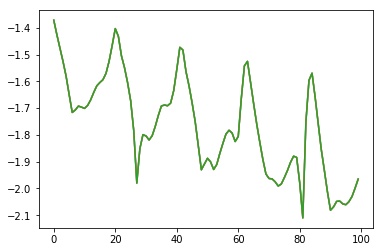

In [18]:
inds = 100

plt.plot(gr_get[:inds])
plt.plot(final_list[:inds])
plt.plot(final_npy[:inds])


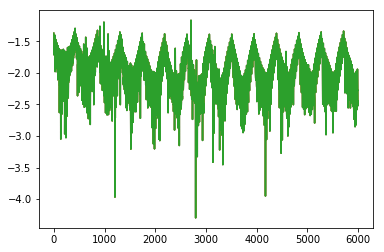

In [19]:
inds = 6000

plt.plot(gr_get[:inds])
plt.plot(final_list[:inds])
plt.plot(final_npy[:inds])

In [33]:
start3 = time.time()
pro_npys = pro_mol[['x','y','z','charge']].values
grid_npy = grid_mol[['x','y','z']].values



mod2 = SourceModule("""
__global__ void doublify2(float *p_a, float *g_a, float *gg_a)
{
for(int iter=0; iter < 3; iter++)
    {
    int idx = iter*9261+threadIdx.x+blockDim.x*blockIdx.x;
    int chk = threadIdx.x+blockDim.x*blockIdx.x;
    
    if (chk < 9262)
        {
        gg_a[chk]+=(p_a[iter]-g_a[idx])*(p_a[iter]-g_a[idx]);
        }
    }
}""")

func = mod2.get_function("doublify2")

final_npy = np.zeros(9261)


pro_npy = pro_npys[10]
get_npy = np.zeros(9261)
grid_npy = grid_npy.astype(np.float32)
pro_npy = pro_npy.astype(np.float32)
get_npy = get_npy.astype(np.float32)

grid_gpu = cuda.mem_alloc(grid_npy.nbytes)
pro_gpu = cuda.mem_alloc(pro_npy.nbytes)
get_gpu = cuda.mem_alloc(get_npy.nbytes)

cuda.memcpy_htod(grid_gpu,grid_npy)
cuda.memcpy_htod(pro_gpu,pro_npy)
cuda.memcpy_htod(get_gpu,get_npy)


func(pro_gpu,grid_gpu, get_gpu,  block = (128,1,1), grid=(73,1))

cuda.memcpy_dtoh(get_npy,get_gpu)
#get_npy1 = pro_npy[3]/np.sqrt(get_npy)
final_npy +=get_npy1
print("time:{:.3f}".format(time.time()-start3))

time:0.202


In [10]:
len(final_npy)

9261

In [31]:
max(get_npy[200:])

0.0

In [35]:
get_npy[0:75]

array([254.83246 , 199.2175  , 223.60254 , 283.80273 , 216.18776 ,
       364.54794 , 384.93298 , 275.13315 , 203.51817 , 211.90321 ,
       218.10341 , 134.48845 , 130.87349 , 207.25853 , 157.45871 ,
       315.81888 , 308.20392 , 260.4041  , 160.78915 , 141.17418 ,
       209.37436 ,  97.7594  ,  66.14445 , 114.52949 , 126.72966 ,
        83.1147  , 259.47488 , 273.67505 , 146.06009 ,  98.44513 ,
       130.83017 ,  89.03035 ,  29.41539 ,  49.80043 , 124.00061 ,
        52.385654, 238.74583 , 255.13087 , 159.33105 ,  83.716095,
        88.10113 , 108.30131 ,  20.686346,  13.071389,  85.456436,
        49.65661 ,  33.932953,  38.317997, 104.51817 ,  16.903217,
         9.28826 ,  81.6733  , 251.84862 , 160.23366 , 148.6187  ,
       160.81888 ,  57.20391 ,  33.58895 ,  89.97399 ,  46.17417 ,
        10.559216,  54.944256, 127.14443 , 205.50461 , 165.88965 ,
        78.190865,  80.391045,  56.859905,  85.24495 , 103.44513 ,
       157.72148 ,  56.215214, 281.51587 ,   0.      ,   0.   